# End to end Mudah Car Section web data scraping
## Data consolidation/analysis and automated mailing to distribution list
### Benefits
- Impossible to manually scraped the entire website. Automated web scraping will help to do the manual work.
- Pre-defined script to parse and analyze the data for high level reporting.
- Can be automated to run in schedule (weekly/monthly/quarterly)
- Help business to make decision with more frequent user generated data.

#### Useful for market researcher, competitor

### Bot Architecture/Flowchart

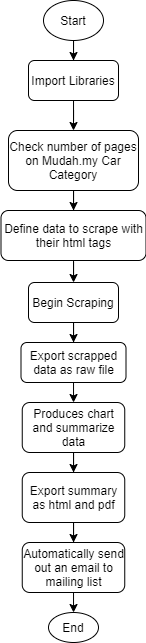

In [1]:
from IPython.display import Image
Image(filename='Flowchart.png') 

In [2]:
# !pip install tqdm
# For progress bar

# !pip install dominate
# To generate html code

# !pip install pdfkit
# Conversion to pdf

In [3]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dominate
import pdfkit 
from datetime import datetime

#### Define Parameters and formatting

In [4]:
# To show all columns, not necessarily need to run
pd.set_option('display.max_columns', None)
# Number formatting to ease reading
pd.options.display.float_format = "{:,.2f}".format

datetoday = datetime.now().strftime("%Y%m%d")

# Set matplotlib/seaborn Style
plt.style.use('seaborn-notebook')
# sns.set_style("darkgrid")
# sns.set_style('ticks')
# sns.set_style("whitegrid")

In [5]:
# For project purpose, here's a mock control DataFrame. In actual use case then just import the DataFrame
control_list = {'Email List': ['aarontanx@gmail.com'], 
                'Salutation': ['Team'], 
                'Report Name': [''.join(['Mudah Car Report ', datetoday, '.pdf'])], 
                'Image Name': ['toyota_model_price.png']
               }

In [6]:
# Base URL (Car Category)
url = 'https://www.mudah.my/list?category=1020&o=1&type=sell'
request = requests.get(url)
soup = BeautifulSoup(request.text, 'html')

#### There are thousands of pages of data. It is impossible to capture all the data by hand

In [7]:
# Check how many pages are there
searchResult = soup.find('div', attrs={"data-testid":"search-result"}).getText()
pageCount = int(re.findall('of ([0-9]*)', searchResult)[0])
print(f'Total of {pageCount} pages')

Total of 1964 pages


In [8]:
# Initiate empty Data Frame to store scraped data
df = pd.DataFrame(columns = ['Title', 'Price', 'Condition', 'Brand', 'Model', 'Type', 'Transmission', 'Capacity', 'Mileage', 'Manufacturing Year', 'URL'])

And apparently mudah only allow access up to 250 pages. Anything > 250 will yield 'result not found'.

It is going to take very long to run 250 pages so we will just run 10 pages instead

In [9]:
pageToRun = 10

In [10]:
# Range 2nd value need to +1
actualPageToRun = pageToRun+1

for i in tqdm(range(1, actualPageToRun)):
    # Loop through all the the pages
    url = f'https://www.mudah.my/list?category=1020&o={i}&type=sell'
    request = requests.get(url)
    soup = BeautifulSoup(request.text, 'html')
    
    # Get all ads html subsection
    adList = soup.findAll("div", {"data-testid" : lambda L: L and L.startswith('listing-ad-item')})
    
    for item in adList:
        newUrl = item.find('a').attrs['href']
        newRequest = requests.get(newUrl)
        newSoup = BeautifulSoup(newRequest.text, 'html')
        
        jsonCode = json.loads(newSoup.find('script', attrs={"id": "__NEXT_DATA__"}).contents[0])
        dictId = list(jsonCode['props']['initialState']['adDetails']['byID'].keys())[0]
        carTitle = jsonCode['props']['initialState']['adDetails']['byID'][dictId]['attributes']['subject']
        finalJson = jsonCode['props']['initialState']['adDetails']['byID'][dictId]['attributes']['categoryParams']
        carPrice = finalJson[0]['value']
        carCondition = finalJson[3]['value']
        carBrand = finalJson[4]['value']
        carModel = finalJson[5]['value']
        carType = finalJson[6]['value']
        carTransmission = finalJson[7]['value']
        carCapacity = finalJson[8]['value']
        carMileage = finalJson[9]['value']
        carMfgYear = finalJson[10]['value']
        
        
        df = df.append({'Title':carTitle, 
                   'Price': carPrice,
                   'Condition': carCondition,
                   'Brand': carBrand,
                   'Model': carModel,
                   'Type': carType,
                   'Transmission': carTransmission,
                   'Capacity': carCapacity,
                   'Mileage': carMileage,
                   'Manufacturing Year': carMfgYear,
                   'URL': newUrl
                  },
                 ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.52s/it]


In [11]:
df.shape # To check the output size

(400, 11)

#### With the data scraped, we are able to do analysis/prediction, create HTML page, converting it to PDF and automate emailing to distribution list

In [12]:
df.to_excel(''.join(['Car Data ', datetoday, '.xlsx']))

In [13]:
df.head()

,Title,Price,Condition,Brand,Model,Type,Transmission,Capacity,Mileage,Manufacturing Year,URL
0,2017 Honda CIVIC TYPE R 2.0 FK8R GT SPEC (M),RM 248 000,Recon,Honda,Civic,Hatchback,Manual,1996 cc,40 000 - 44 999,2017,https://www.mudah.my/2017+Honda+CIVIC+TYPE+R+2...
1,2018 Toyota HARRIER 2.0 GR Sport TURBO Japan U...,RM 219 800,Recon,Toyota,Harrier,SUVs,Auto,1998 cc,20 000 - 24 999,2018,https://www.mudah.my/2018+Toyota+HARRIER+2+0+G...
2,2020 Toyota ALPHARD 2.5 SC JBL F/SPEC JAPAN UNREG,RM 319 800,Recon,Toyota,Alphard,MPVs,Auto,2493 cc,15 000 - 19 999,2020,https://www.mudah.my/2020+Toyota+ALPHARD+2+5+S...
3,Toyota ALPHARD 3.5 GF LOCAL FSR U/WARRANTY 2023,RM 295 777,Used,Toyota,Alphard,MPVs,Auto,3456 cc,25 000 - 29 999,2018,https://www.mudah.my/Toyota+ALPHARD+3+5+GF+LOC...
4,2017 Mercedes Benz E200 AVANTGARDE 2.0 9G JAPAN,RM 229 800,Recon,Mercedes Benz,E200,Sedan,Auto,1991 cc,50 000 - 54 999,2017,https://www.mudah.my/2017+Mercedes+Benz+E200+A...


In [14]:
# Convert string price to float for analysis
df['Price in Number'] = df['Price'].apply(lambda x: float(x[2:].replace(' ', '')))

# Convert capacity to integer for analysis
df['Capacity in Number'] = df['Capacity'].apply(lambda x: int(x[:len(x)-2].replace(' ', '')))


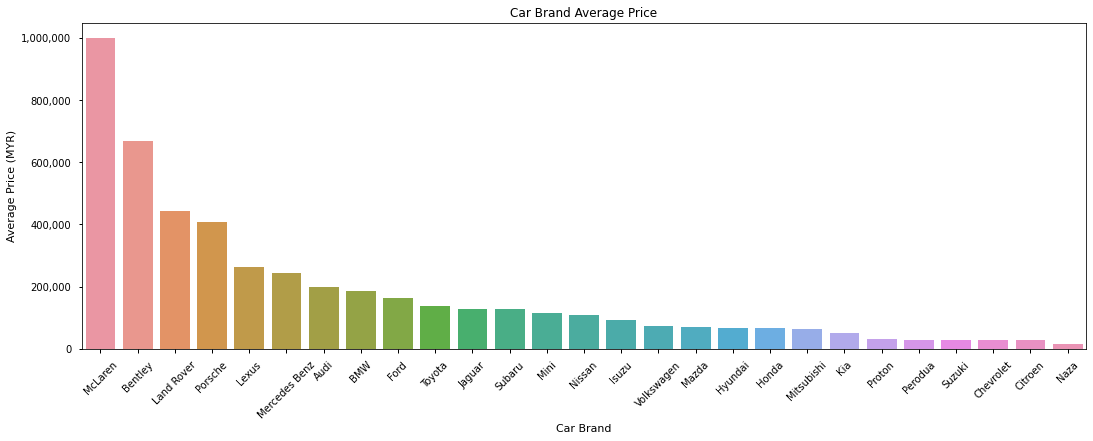

In [15]:
# Get average price for each brand
brandSummary = df.groupby(['Brand']).mean('Price in Number').sort_values(by='Price in Number', ascending = False).reset_index()
plt.figure(figsize=(18,6))
plt.xticks(rotation=45)
brandPricePlot = sns.barplot(data = brandSummary, x = 'Brand', y = 'Price in Number')
brandPricePlot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Car Brand Average Price')
plt.xlabel('Car Brand')
plt.ylabel('Average Price (MYR)')
plt.savefig('car_brand_avg_price.png')

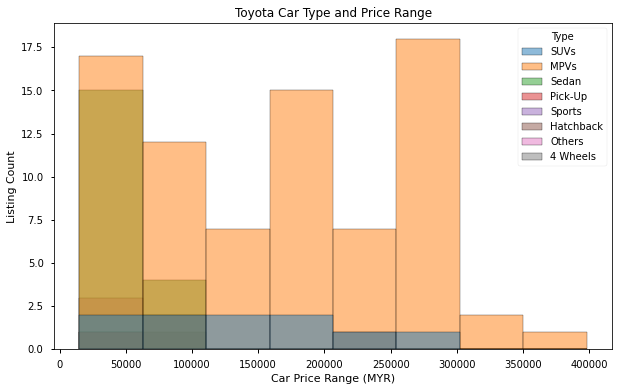

In [16]:
# Toyota Car Analysis
# Car Type and Price
toyotaData = df[df['Brand'] == 'Toyota'].copy()

plt.figure(figsize=(10,6))
plt.title('Toyota Car Type and Price Range')
plt.xlabel('Car Price Range (MYR)')
plt.ylabel('Listing Count')
sns.histplot(data = toyotaData, x = 'Price in Number', hue= 'Type')

plt.savefig('toyota_type_price.png')

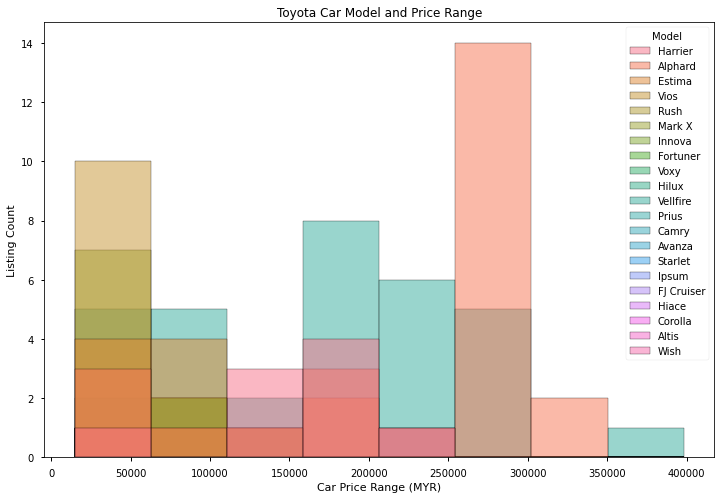

In [17]:
# Toyota Car Analysis

plt.figure(figsize=(12,8))
plt.title('Toyota Car Model and Price Range')
plt.xlabel('Car Price Range (MYR)')
plt.ylabel('Listing Count')
sns.histplot(data = toyotaData, x = 'Price in Number', hue= 'Model')

plt.savefig('toyota_model_price.png')

In [18]:
# Summarize Car Brand with their price and capacity
brandPriceStat = df[['Brand', 'Price in Number']].rename({'Price in Number': 'Price'}).groupby('Brand').describe()
brandCapacityStat = df[['Brand', 'Capacity in Number']].rename({'Capacity in Number': 'Capacity'}).groupby('Brand').describe()

In [19]:
brandPriceStat.head()

Price in Number                                              \
                    count       mean        std        min        25%   
Brand                                                                   
Audi                 4.00 199,375.00 203,136.18  59,900.00  82,325.00   
BMW                  9.00 186,108.44 122,813.40  28,000.00  91,800.00   
Bentley              2.00 668,000.00 254,558.44 488,000.00 578,000.00   
Chevrolet            1.00  27,500.00        NaN  27,500.00  27,500.00   
Citroen              1.00  26,800.00        NaN  26,800.00  26,800.00   

                                            
                 50%        75%        max  
Brand                                       
Audi      119,300.00 236,350.00 499,000.00  
BMW       166,000.00 235,800.00 428,000.00  
Bentley   668,000.00 758,000.00 848,000.00  
Chevrolet  27,500.00  27,500.00  27,500.00  
Citroen    26,800.00  26,800.00  26,800.00

In [20]:
brandCapacityStat.head()

Capacity in Number                                               \
                       count     mean      std      min      25%      50%   
Brand                                                                       
Audi                    4.00 2,017.50   633.33 1,395.00 1,697.25 1,891.00   
BMW                     9.00 2,217.44   502.99 1,499.00 1,997.00 1,998.00   
Bentley                 2.00 4,995.50 1,417.75 3,993.00 4,494.25 4,995.50   
Chevrolet               1.00 1,998.00      NaN 1,998.00 1,998.00 1,998.00   
Citroen                 1.00 1,598.00      NaN 1,598.00 1,598.00 1,598.00   

                             
               75%      max  
Brand                        
Audi      2,211.25 2,893.00  
BMW       2,494.00 2,998.00  
Bentley   5,496.75 5,998.00  
Chevrolet 1,998.00 1,998.00  
Citroen   1,598.00 1,598.00

In [21]:
# Convert Dataframe to html format
brandPriceStathtml = brandPriceStat.to_html()
brandCapacityStathtml = brandCapacityStat.to_html()

In [22]:
from dominate.tags import *
from dominate.util import raw

title = "Car Listing Report " + str(datetoday)
doc = dominate.document(title=title)

with doc.head:
    link(rel='stylesheet', href='style.css')
    script(type='scripts/javascript', src='script.js')

with doc:
    with div(id="header"):
        attr(cls='body')
        img(src='https://upload.wikimedia.org/wikipedia/commons/c/c2/Mudah.my_Sdn_Bhd_Logo_%28as_of_2014%29.jpg', alt='mudah logo')
        h1(title)
        
    with div(id="carprice"):
        attr(cls='body')
        img(src='car_brand_avg_price.png', alt='car_brand_avg_price',style="width:1200px;height:400px;")
        
    with div(id="carbrandstat"):
        attr(cls='body')
        h1('Car Brand Stats')
        h2('Price')
        raw(brandPriceStathtml)
        br()
        br()
        br()
        h2('Capacity')
        raw(brandCapacityStathtml)
        
        
    with div(id="ToyotaAnalysis"):
        attr(cls='body')
        h1('Toyota Analysis')
        img(src='toyota_type_price.png', alt='toyota type price')

with open(''.join(['Mudah Car Report ', datetoday, '.html']), 'w') as f:
    f.write(doc.render())

#### With the HTML created, we can generate PDF Report to send out

In [23]:
path_wkhtmltopdf = r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe'
config = pdfkit.configuration(wkhtmltopdf=path_wkhtmltopdf)

options = {
  "enable-local-file-access": None
}

pdfkit.from_file(''.join(['Mudah Car Report ', datetoday, '.html']), ''.join(['Mudah Car Report ', datetoday, '.pdf']), configuration=config, options= options) 

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


True

#### Send out as an email

In [24]:
email_subject = ''.join(["Mudah car price report ", datetoday])
email_body = """\
<html>
  <head></head>
  <body>
    <p>
        Hi Team, <br>
    <br>
        Attached is Mudah's Car Price report for today.<br>
    <br>
        Toyota Car Model with their price range.
    <br>
        <img src="cid:image0" alt="image"><br>
    <br>
        Regards, <br>
        Automation Bot <br>
    </p>
  </body>
</html>
"""

In [25]:
def generate_email(sender, email_list, subject, body, salutation, attachment, image):
    
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email.mime.image import MIMEImage
    from email.mime.application import MIMEApplication
    import os
    
    message = MIMEMultipart()
    message['From'] = sender
    message['To'] = email_list
    message['Subject'] = subject
    body = body.replace("$(salutation)", salutation)
    message.attach(MIMEText(body, 'html'))
    
    # Add attachment
    attachment_file = open(attachment, 'rb')
    file = MIMEApplication(attachment_file.read(), name=os.path.basename(attachment))
    file['Content-Disposition'] = f'attachment; filename="{os.path.basename(attachment)}"'
    message.attach(file)
    
#     Add image
    img = open(image, 'rb')
    msgImage = MIMEImage(img.read())
    img.close()
    msgImage.add_header('Content-ID', '<image0>')
    message.attach(msgImage)
    
    message_str = message.as_string()
    
    return message_str

def send_email(sender, password, email_list, email):
    
    import smtplib
    
    session = smtplib.SMTP('smtp.gmail.com', 587)  
    session.starttls() 
    session.login(sender, password) 
    to_list = email_list.split(",")
    
    session.sendmail(sender, to_list, email)
    session.quit()

In [26]:
sender_email = '***'
sender_password = '***'
control_list = pd.DataFrame(control_list)

for i, control in control_list.iterrows():
    email = generate_email(sender_email, 
                          control["Email List"], 
                          email_subject, 
                          email_body, 
                          control["Salutation"], 
                          control["Report Name"],
                          control["Image Name"])
    send_email(sender_email, sender_password, control["Email List"], email)
    
    print('Email Sent to ' + control["Email List"])

Email Sent to aarontanx@gmail.com


### Further enhancement
- Can automate it to run monthly using task scheduler
- HTML generated can be hosted in intranet site for internal consumption instead of spamming emails
- Archive exported raw file to cloud storage
- Scrape from other sites that list similar product. Can aggregate to get a better picture of the used-car market